In [6]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely

from matplotlib import pyplot as plt
from cycler import cycler
import geoplot as gplt
import geoplot.crs as gcrs


import ee
import rasterio
from rasterio.plot import show as showRasterio


In [7]:
newFileName = 'june2023.csv'
os.chdir('spatial')
ffp = {}
ffp['xr'] = pd.read_csv('ATM_fluxMap_x_'+newFileName,header = None) # x-coordinates
ffp['yr'] = pd.read_csv('ATM_fluxMap_y_'+newFileName,header = None) # y-coordinates
ffp['co2'] = pd.read_csv('ATM_fluxMap_co2_'+newFileName,header = None) # CO2 spatial data
ffp['ch4'] = pd.read_csv('ATM_fluxMap_ch4_'+newFileName,header = None) # CH4 spatial data
ffp['h'] = pd.read_csv('ATM_fluxMap_h_'+newFileName,header = None) # Sensible heat spatial data
os.chdir('..')

In [8]:
tower_loc = [41.701827, -87.996285]
r_earth = 6378137.0 # approx radius of earth in m
meters_per_lon = (np.pi/180) * r_earth * np.cos(tower_loc[0]*np.pi/180)

In [9]:
def lat_to_m(degree, ref_point):
    meter = (degree-ref_point[0])/(1/111000) # 111km per deg of latitude
    return meter

def lon_to_m(degree):
    meter = (degree-ref_point[1])/(1/85000)
    return meter

def m_to_lat(meter):
    new_latitude  = tower_loc[0]  + (meter / r_earth) * (180 / np.pi)
    return new_latitude

def m_to_lon(meter, latitude):
    new_longitude = tower_loc[1] + (meter / r_earth) * (180 / np.pi) / np.cos(latitude * np.pi/180)
    return new_longitude

def gridtodf(grid, name):
    df = (pd.DataFrame(grid).stack(dropna = False).reset_index(name = name))
    return df[name]

ffp['lat'] = m_to_lat(ffp['yr'])
ffp['lon'] = m_to_lon(ffp['xr'], ffp['lat'])

df = pd.DataFrame()
for gname in ffp: 
    df.loc[:, gname] = gridtodf(ffp[gname], name = gname)

gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df['lon'], df['lat'], crs = "EPSG: 4326"))
# gdf = gdf.rotate()
# gdf.rotate(180)
# for index, row in gdf.iterrows():
#     rotated = shapely.affinity.rotate(row['geometry'], 180)
#     gdf.loc[index, 'geometry'] = rotated
gdf

,xr,yr,co2,ch4,h,lat,lon,geometry
0,-400,400,NaN,NaN,NaN,41.705420,-88.001098,POINT (-88.00110 41.70542)
1,-392,400,NaN,NaN,NaN,41.705420,-88.001002,POINT (-88.00100 41.70542)
2,-384,400,NaN,NaN,NaN,41.705420,-88.000905,POINT (-88.00091 41.70542)
3,-376,400,NaN,NaN,NaN,41.705420,-88.000809,POINT (-88.00081 41.70542)
4,-368,400,NaN,NaN,NaN,41.705420,-88.000713,POINT (-88.00071 41.70542)
...,...,...,...,...,...,...,...,...
10196,368,-400,NaN,NaN,NaN,41.698234,-87.991858,POINT (-87.99186 41.69823)
10197,376,-400,NaN,NaN,NaN,41.698234,-87.991761,POINT (-87.99176 41.69823)
10198,384,-400,NaN,NaN,NaN,41.698234,-87.991665,POINT (-87.99167 41.69823)
10199,392,-400,NaN,NaN,NaN,41.698234,-87.991569,POINT (-87.99157 41.69823)


In [10]:
bbox = shapely.geometry.Polygon([
    (df['lon'].iloc[0], df['lat'].iloc[0]),
    (df['lon'].iloc[10200], df['lat'].iloc[0]),
    (df['lon'].iloc[10200], df['lat'].iloc[10200]),
    (df['lon'].iloc[0], df['lat'].iloc[10200])
])

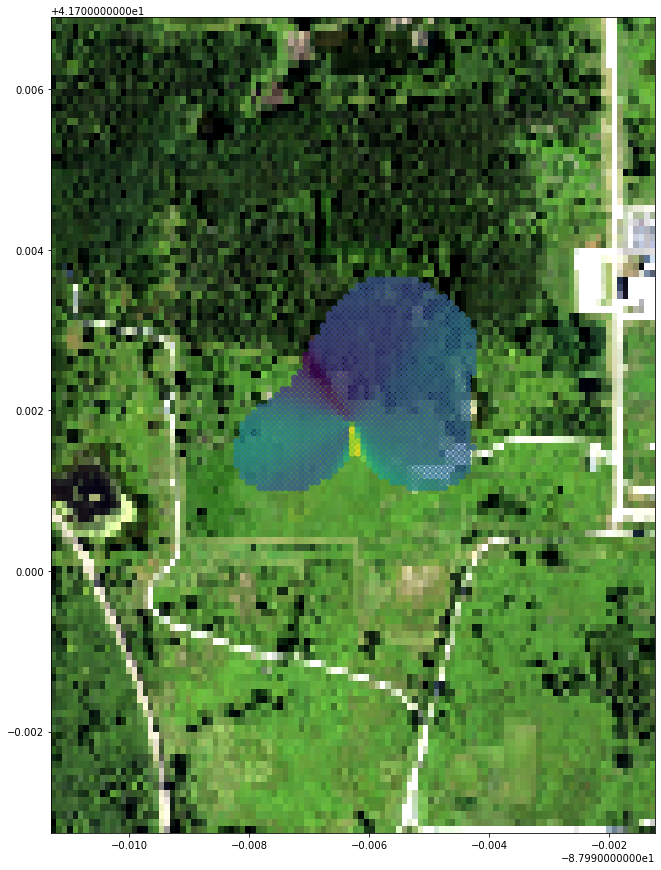

In [16]:
f,ax = plt.subplots(figsize=(15,15))

ATMOS = rasterio.open('ATMOS_NAIP_0.01.tif')
rasterio.plot.show(ATMOS.read(), ax = ax, transform=ATMOS.transform)
gdf.plot(ax=ax, c = gdf.loc[:,'ch4'], alpha = 0.7, kind = 'geo')

plt.savefig(f'output/atmos_ffp_NAIP_0.01.png')
ATMOS.close()

<AxesSubplot:>

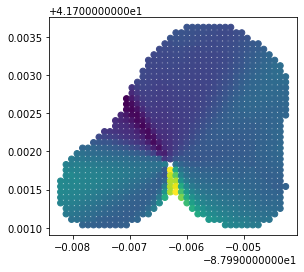

In [45]:
gdf.plot(c = gdf['ch4'], kind = 'geo')

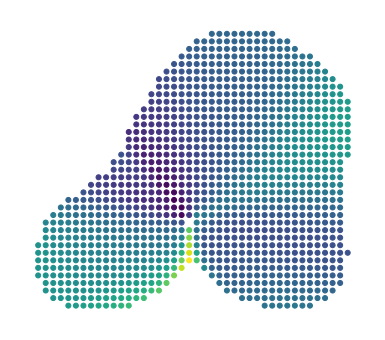

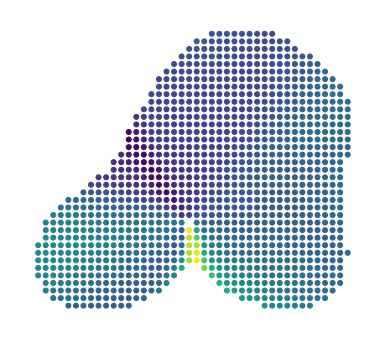

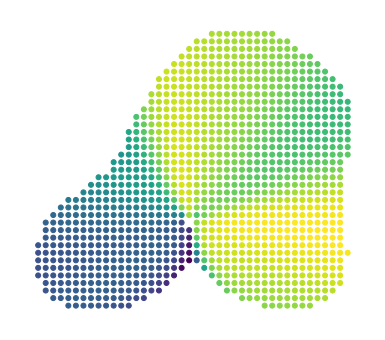

In [56]:
for flux in ['co2', 'ch4', 'h']:
    gplt.pointplot(gdf[gdf[flux].notnull()], projection=gcrs.WebMercator(), hue = flux)
#     gplt.choropleth(gdf[gdf[flux].notnull()], projection=gcrs.WebMercator(), hue = flux)
#     gplt.kdeplot(gdf[gdf[flux].notnull()], projection=gcrs.WebMercator(), shade = True, cmap = 'viridis')